### Explainability using Integrated Gradients for Natural Language Processing
(An amazing approach suggested in the paper https://arxiv.org/pdf/1703.01365.pdf,
allows us to attribute importance to each feature input,
regardless of model architecture)

---



In [ ]:
# Import all the libraries
import os
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize, rgb2hex
import pandas as pd
from IPython.display import HTML


pd.set_option('display.max_colwidth', 150)


In [ ]:
# download the ag_news_subset dataset; https://www.tensorflow.org/datasets/catalog/ag_news_subset
# split them into train/val/test, train:val = 90:10
(raw_train_ds, raw_val_ds, raw_test_ds), info = tfds.load('ag_news_subset',
                                                          split=['train[:90%]',
                                                                 'train[-90%:]',
                                                                 'test'],
                                                          with_info=True)


Shuffling and writing examples to /root/tensorflow_datasets/ag_news_subset/1.0.0.incomplete00CC8H/ag_news_subset-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ag_news_subset/1.0.0.incomplete00CC8H/ag_news_subset-test.tfrecord


Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


In [ ]:
_LABEL_NAMES = info.features['label'].names
print(_LABEL_NAMES)

['World', 'Sports', 'Business', 'Sci/Tech']


In [ ]:
batch_size = 128

In [ ]:
# convert a sample of dataset into pandas df for easy viewing
train_sample_df = \
    tfds.as_dataframe(raw_train_ds.shuffle(batch_size).take(5),
                      ds_info=info)[['description', 'label']]
train_sample_df['topic'] = \
    train_sample_df['label'].apply(lambda x: _LABEL_NAMES[x])

In [ ]:
(train_sample_df.head())

,description,label,topic
0,b' KHARTOUM (Reuters) - Sudan on Monday ruled out any notion of self-rule for Darfur and said rebels in the western region would not secure the ...,0,World
1,b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stem...,1,Sports
2,"b""Reuters - Ghana's President John Kufuor won a\\second and final four-year mandate in the world's number two\\cocoa grower on Thursday after taki...",0,World
3,"b'Within two weeks of the firing of CEO Craig Conway, business applications vendor PeopleSoft Inc. has seen the departure of another top executive...",3,Sci/Tech
4,"b""NEW YORK - While Oracle Corp. awaits a judge's decision on whether it can continue in its quest to acquire PeopleSoft Inc., the company faced a ...",3,Sci/Tech


The Model's goal is to predict the topic (label) given the description.

In [ ]:
# Need to covert the dataset from dict to tuple;

@tf.autograph.experimental.do_not_convert
def convert_ds_to_tuple(sample):

    """ the original dataset is of the form of a dict
     {description: (), label: (), title: ()}

      TF's model.fit() method required datasets to be of the form
      A tf.data dataset that returns a tuple of (inputs, targets)"""

    return sample['description'], sample['label']


# converting all datasets from dicts to tuples
raw_train_ds = raw_train_ds.map(convert_ds_to_tuple).batch(batch_size)
raw_val_ds = raw_val_ds.map(convert_ds_to_tuple).batch(batch_size)
raw_test_ds = raw_test_ds.map(convert_ds_to_tuple).batch(batch_size)


In [ ]:
# initiating model building;
# build the tokenizer layer first
vocab_size = 1000
e_dim = 64
n_classes = info.features['label'].num_classes
pre_processing_layer = TextVectorization(max_tokens=vocab_size,
                                         output_sequence_length=50,
                                         name='Notes_preprocessing_layer')

# fit the training set to the layer
pre_processing_layer.adapt(raw_train_ds.map(lambda x, y: x))
# store the vocab
vocab = pre_processing_layer.get_vocabulary()

In [ ]:
# vectorize the text inputs

@tf.autograph.experimental.do_not_convert
def vectorize_text(text, label):

    """ convert text to tokens """

    text = tf.expand_dims(text, -1)
    return pre_processing_layer(text), label


# print an example
text_batch, label_batch = next(iter(raw_train_ds.shuffle(50)))
first_review, first_label = text_batch[0], label_batch[0]
print("Review: ", first_review)
print("Label: ", _LABEL_NAMES[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))


Review:  tf.Tensor(b'ATi presenta la scheda PCI Express ALL-IN-WONDER X600 PRO. La scheda sar disponibile il prossimo mese in Europa e Nord America ed  adatta a chi vuole fare del computer una piattaforma multimediale e non solo adatta agli ultimi games in commercio.', shape=(), dtype=string)
Label:  Sci/Tech
Vectorized review (<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   6,   1,   1,   1, 380,   1,   1,   3,   1,   1,
          1,   1, 146,   1,   1,   1,   1,   1,   1,   1,   1,   1, 202,
          6,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)


In [ ]:
# tokenize all datasets and prepare for training
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Build the model
# lets build a simple Bi-directional LSTM model
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=e_dim,
                              name='embedding',
                              mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax', name='probs')
])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
probs (Dense)                (None, 4)                 68        
Total params: 89,940
Trainable params: 89,940
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# train the model; lets try for 5 epochs
model.fit(train_ds, validation_data=val_ds, epochs=5, verbose=1)

Epoch 1/5
844/844 [==============================] - 38s 31ms/step - loss: 0.5425 - sparse_categorical_accuracy: 0.7967 - val_loss: 0.4043 - val_sparse_categorical_accuracy: 0.8574
Epoch 2/5
844/844 [==============================] - 17s 21ms/step - loss: 0.4038 - sparse_categorical_accuracy: 0.8546 - val_loss: 0.3803 - val_sparse_categorical_accuracy: 0.8646
Epoch 3/5
844/844 [==============================] - 17s 20ms/step - loss: 0.3856 - sparse_categorical_accuracy: 0.8599 - val_loss: 0.3641 - val_sparse_categorical_accuracy: 0.8684
Epoch 4/5
844/844 [==============================] - 18s 22ms/step - loss: 0.3707 - sparse_categorical_accuracy: 0.8644 - val_loss: 0.3513 - val_sparse_categorical_accuracy: 0.8722
Epoch 5/5
844/844 [==============================] - 18s 21ms/step - loss: 0.3563 - sparse_categorical_accuracy: 0.8694 - val_loss: 0.3392 - val_sparse_categorical_accuracy: 0.8769


In [ ]:
# evaluate the model
model.evaluate(test_ds, verbose=2)


60/60 - 1s - loss: 0.3934 - sparse_categorical_accuracy: 0.8567


[0.3933546245098114, 0.8567105531692505]

In [ ]:
# get predictions
test_probs = model.predict(test_ds)
test_preds = tf.argmax(test_probs, axis=1)
test_labels = \
    test_ds.flat_map(lambda x, y:
                     tf.data.Dataset.from_tensor_slices(y)).as_numpy_iterator()
test_labels = tf.convert_to_tensor(list(test_labels), dtype=test_preds.dtype)

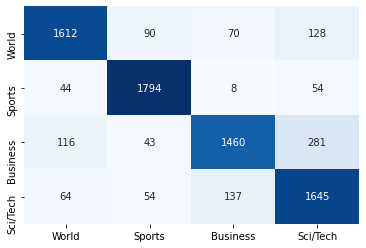

In [ ]:
# build confusion matrix
cm = tf.math.confusion_matrix(test_labels, test_preds)

# plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=_LABEL_NAMES,
            yticklabels=_LABEL_NAMES, cbar=False)
plt.show()

### INTEGRATED GRADIENTS for understanding feature importance
Refer to https://arxiv.org/pdf/1703.01365.pdf for all the details


##### VERY IMPORTANT : in Tensorflow, gradients dont pass through Embedding layer; so will get the embedding layer out, and build the rest of the model as `new_model`


In [ ]:
embed_layer = model.get_layer('embedding')

# build new model with all layers after embedding layer
new_model = tf.keras.Sequential()
for layer in model.layers[1:]:
    new_model.add(layer)

In [ ]:
# take some test data
sample_vectors = next(test_ds.take(1).as_numpy_iterator())[0]
sample_texts = next(raw_test_ds.take(1).as_numpy_iterator())[0]
sample_labels = next(test_ds.take(1).as_numpy_iterator())[1]

Run all the code below this line to visualize a different example

In [ ]:
# select a random index
index = tf.cast(tf.random.uniform(shape=[1],
                                  minval=sample_vectors.shape[0]),
                dtype=tf.int8).numpy()[0]
# generate a random sample
sample_text = sample_texts[index]
sample_vector = sample_vectors[index]
sample_label = sample_labels[index]
# get embeddings
sample_embed = embed_layer(sample_vector)
# Create a Baseline vector with zero embeddings
baseline_embed = tf.zeros(shape=tf.shape(sample_embed))
# get preds for sample
sample_preds = model(sample_vectors)[index]
# print the results with color codes
words = [vocab[i] for i in sample_vector]

In [ ]:
def interpolate_texts(baseline, text, m_steps):

    """ Linearly interpolate the input vector
    (embedding layer output of the sample vector)"""

    # Generate m_steps intervals for integral_approximation() below.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    # text = tf.cast(text, tf.float32)
    alphas_x = alphas[:, tf.newaxis, tf.newaxis]
    delta = text - baseline
    texts = baseline + alphas_x * delta
    return texts

In [ ]:
n_steps = 50

interpolated_texts = interpolate_texts(baseline_embed,
                                       sample_embed,
                                       n_steps)

In [ ]:
interpolated_texts.shape
# (num_interpolations, seq_len, embed_dim)

TensorShape([51, 50, 64])

In [ ]:
def compute_gradients(t, target_class_idx):

    """ compute the gradient wrt to embedding layer output """

    with tf.GradientTape() as tape:
        tape.watch(t)
        probs = new_model(t)[:, target_class_idx]
    grads = tape.gradient(probs, t)
    return grads

In [ ]:
target_label = sample_label
# target_label = 2
path_gradients = compute_gradients(interpolated_texts, target_label)

In [ ]:
path_gradients.shape
# (num_interpolations, seq_len, embed_dim)

TensorShape([51, 50, 64])

In [ ]:
# sum the grads of the interpolated vectors
all_grads = tf.reduce_sum(path_gradients, axis=0) / n_steps
# mulitply grads by (input - baseline); baseline is zero vectors
x_grads = tf.math.multiply(all_grads, sample_embed)
# sum all gradients across the embedding dimension
igs = tf.reduce_sum(x_grads, axis=-1).numpy()

In [ ]:
# took the code for this cell block from
#  https://docs.seldon.io/projects/alibi/en/stable/examples/integrated_gradients_imdb.html

def  hlstr(string, color='white'):
    """
    Return HTML markup highlighting text with the desired color.
    """
    return f"<mark style=background-color:{color}>{string} </mark>"


def colorize(attrs, cmap='PiYG'):
    """
    Compute hex colors based on the attributions for a single instance.
    Uses a diverging colorscale by default and normalizes and scales
    the colormap so that colors are consistent with the attributions.
    """

    cmap_bound = tf.reduce_max(tf.abs(attrs))
    norm = Normalize(vmin=-cmap_bound, vmax=cmap_bound)
    cmap = mpl.cm.get_cmap(cmap)

    # now compute hex values of colors
    colors = list(map(lambda x: rgb2hex(cmap(norm(x))), attrs))
    return colors

In [ ]:
colors = colorize(igs)

In [ ]:
# print the sample and predictions
print(f"Sample Text: {sample_text}\n")
# print(f"Sample Vector: {sample_vector}")
# print(f"True Label: {_LABEL_NAMES[sample_label]}")
# print(f"Predicted Label: "
#       f"{_LABEL_NAMES[tf.argmax(sample_preds).numpy()]}")
print("Predictions : ")
for index in tf.argsort(sample_preds,
                        axis=-1, direction='DESCENDING').numpy():
    print(f"\t{_LABEL_NAMES[index]} --> {sample_preds[index]*100:0.2f}%")

print(f"\nTrue Label: {_LABEL_NAMES[sample_label]}")
print(f"\nAttributions for Label: {_LABEL_NAMES[target_label]}")
print(f"\nTop 5 Important words: "
      f"{[words[i] for i in tf.argsort(igs, -1, 'DESCENDING')[:5]]}\n")
HTML("".join(list(map(hlstr, words, colors))))

Sample Text: b"Investor's Business Daily - With Philadelphia's recent proposal to install a citywide broadband wireless network, will there be brotherly love between the city and its broadband service providers?"

Predictions : 
	Sci/Tech --> 93.34%
	Business --> 5.80%
	World --> 0.85%
	Sports --> 0.00%

True Label: Sci/Tech

Attributions for Label: Sci/Tech

Top 5 Important words: ['wireless', 'network', 'recent', 'service', 'business']



Importance of the words are highlighted. Greener the color, the higher positive attribution of that feature towards the prediction. Opposite for pink-colored words. As you can see, features such as 'olympic', 'champions`, 'league' are contributing the most towards predicting the sample as 'Sports'

